# Import Libraries

In [15]:
import pandas as pd, numpy as np
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly_express as px

sns.set_style("whitegrid") # set some seaborn styles
#sns.set_style("ticks")

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_colwidth", 500)

# Import Data

In [16]:
df_raw = pd.read_csv("../data_raw/multiple_choice_responses_2019.csv", low_memory=False)

# 1. Review / cleaning 

As most cols are dummy vars we dont drop cols with hight perc isnull

In [17]:
df = df_raw.copy() 

In [18]:
# extract question
questions = df.iloc[0,:]

In [19]:
# drop questions
df = df.drop(df.index[0])

In [20]:
# check and drop duplicates
df = df.drop_duplicates()

In [21]:
# drop columns
## possible to drop later: Q16, Q17, Q20, Q30, Q31, Q32

drop_all = ["Q26", "Time from Start to Finish", "Q11", "Q19"]
#df[df.columns.drop(list(df.filter(regex="Q26", "OTHER", "Time from Start to Finish (seconds)", "Q11", "Q19")))]

for col in drop_all:
    df = df.loc[:,~df.columns.str.contains(col)]
    

In [22]:
rename = {"Q1" : "age",
          "Q2" : "gender",
          "Q3" : "country",
          "Q4" : "degree",
          "Q5" : "position",
          "Q6" : "company_size",
          "Q7": "team_size",
          "Q10": "salary(yrl)"
          }
df = df.rename(columns=rename)

# 2. Extract subsets
for further steps we extract the relevant countries

In [23]:
india = df[df["country"] == "India"]

In [24]:
usa = df[df["country"] == "United States of America"]

## 2.1 some plotting

In [25]:
def perc(df, col):
    return round(100 * df[col].value_counts(normalize=True),2).to_frame()

### 2.1. Sample 

In [26]:
df_comp = df[(df["country"] == "India") | (df["country"] == "United States of America")].copy()

In [63]:
df_country = df_comp[["country"]]

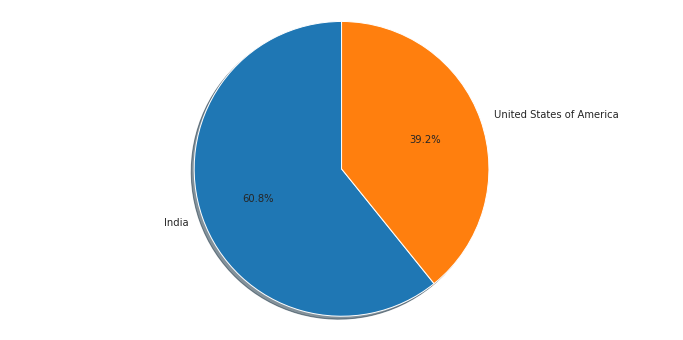

In [28]:
labels = df_country["country"].value_counts().keys().tolist()
sizes = [len(india), len(usa)]

fig1, ax1 = plt.subplots(figsize=(12,6))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [29]:
global_gender_dist = perc(df, "gender").rename(columns={"gender" : "global"})
india_gender_dist = perc(india, "gender").rename(columns={"gender" : "india"})
usa_gender_dist = perc(usa, "gender").rename(columns={"gender" : "usa"})

df_gender = global_gender_dist.merge(right=india_gender_dist, how="inner", left_index=True, right_index=True)
df_gender= df_gender.merge(right=usa_gender_dist, how="inner", left_index=True, right_index=True)

### 2.1.0 Fig Standards

In [30]:
figure_size = (12,6)

### 2.1.1 Gender

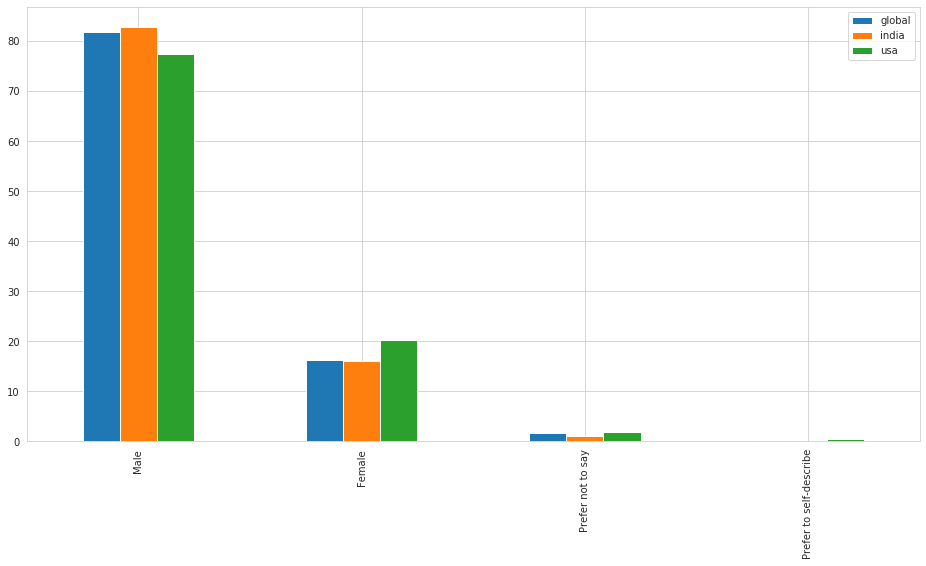

In [31]:
fig, ax = plt.subplots(figsize=(16, 8))
df_gender.plot(kind="bar", ax=ax);

### 2.1.2 Age

In [32]:
global_age_dist = perc(df, "age").rename(columns={"age" : "global"})
india_age_dist = perc(india, "age").rename(columns={"age" : "india"})
usa_age_dist = perc(usa, "age").rename(columns={"age" : "usa"})

df_age = global_age_dist.merge(right=india_age_dist, how="inner", left_index=True, right_index=True)
df_age = df_age.merge(right=usa_age_dist, how="inner", left_index=True, right_index=True)
df_age = df_age.reset_index()
df_age = df_age.rename(columns={"index": "age"}).sort_values(by="age")
df_age = df_age.set_index("age")

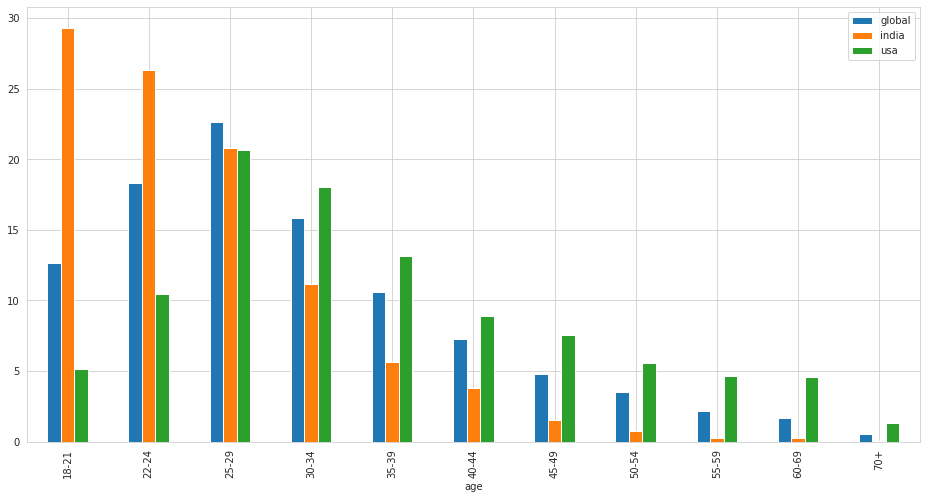

In [33]:
fig, ax = plt.subplots(figsize=(16, 8))
df_age.plot(kind="bar", ax=ax);

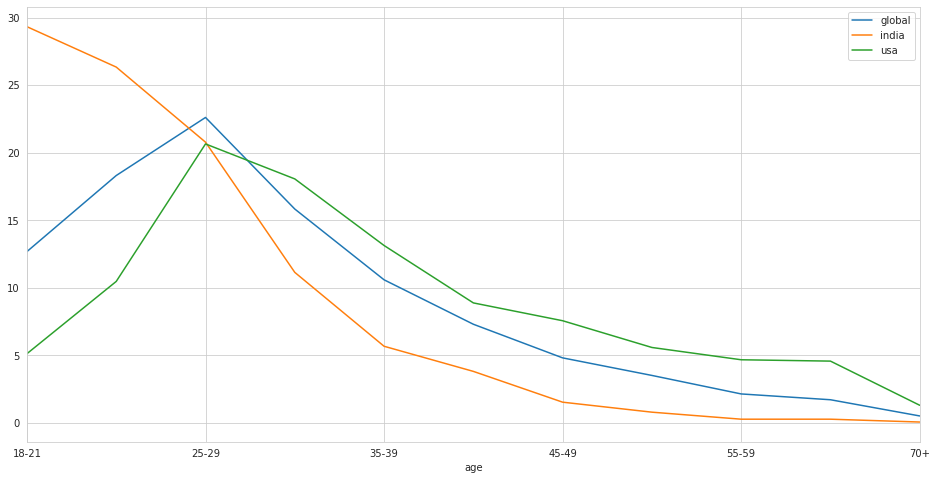

In [34]:
fig, ax = plt.subplots(figsize=(16, 8))
df_age.plot(kind="line", ax=ax);

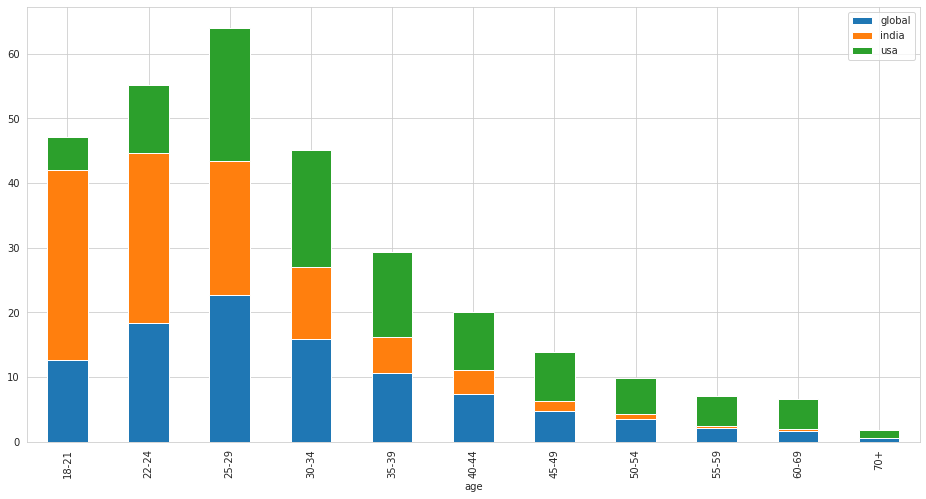

In [35]:
fig, ax = plt.subplots(figsize=(16, 8))
df_age.plot(kind="bar", ax=ax, stacked=True);

## Development of technical resources

In [36]:
# company size

global_company_size_dist = perc(df, "company_size").rename(columns={"company_size" : "global"})
india_company_size_dist = perc(india, "company_size").rename(columns={"company_size" : "india"})
usa_company_size_dist = perc(usa, "company_size").rename(columns={"company_size" : "usa"})
df_company_size = global_company_size_dist.merge(right=india_company_size_dist, how="inner", left_index=True, right_index=True)
df_company_size = df_company_size.merge(right=usa_company_size_dist, how="inner", left_index=True, right_index=True)
df_company_size = df_company_size.reset_index().rename(columns={"index" : "company_size"}).sort_values("company_size").set_index("company_size")
df_company_size = df_company_size.reindex(index = ["0-49 employees", "50-249 employees", "250-999 employees", "1000-9,999 employees", "> 10,000 employees"])

In [37]:
def undummy(df, col_pattern, labels_only=False):
    df_tmp = df.loc[:,df.columns.str.contains(col_pattern)]
    cols_to_bool = list(df_tmp.columns)

    df_tmp = df_tmp.fillna(0)

    labels = []
    for col in cols_to_bool:
        labels.append(df_tmp[col].value_counts().keys()[1])


    for col in cols_to_bool:
        df_tmp[col] = np.where(df_tmp[col] != 0, 1, 0)
        df_tmp[col] = df_tmp[col].astype(int)

    resources = []
    for col in cols_to_bool:
        resources.append(df_tmp[col].sum())

    labels

    resources = pd.DataFrame(data=resources, index=labels)
#     resources = resources.drop("6")
    resources = resources.rename(columns={0: "value"})
    resources = resources.sort_values(by="value", ascending=False)
    
    if labels_only == True:
        return labels
    return resources


In [38]:
def undummy_single_col(df, col_name):
    sr_tmp = df[col_name]
    sr_tmp = sr_tmp.fillna(0)

    labels = sr_tmp.value_counts().keys().tolist()
    labels = pd.Series(labels).astype(str)
    labels = labels.str.replace("0", "None")

    resources = sr_tmp.value_counts().tolist()
    
    resources = pd.DataFrame(data=resources, index=labels)
    resources = resources.rename(columns={0: "value"})
    resources = resources.sort_values(by="value", ascending=False)

    return resources


In [39]:
def total_to_perc(df, df1, df2, col1, col2):
    df_perc = df
    df_perc = df_perc.drop(columns=[col1, col2])
    df_perc = df_perc.assign(india = df[col1].apply(lambda x: (x/len(df1))*100))
    df_perc = df_perc.assign(usa = df[col2].apply(lambda x: (x/len(df2))*100))
    return df_perc

In [40]:
resources_india = undummy(india, "Q13")
resources_usa = undummy(usa, "Q13")

resources = resources_india.merge(right=resources_usa, how="inner", left_index=True, right_index=True)
resources = resources.rename(columns={"value_x": "india", "value_y": "usa"})

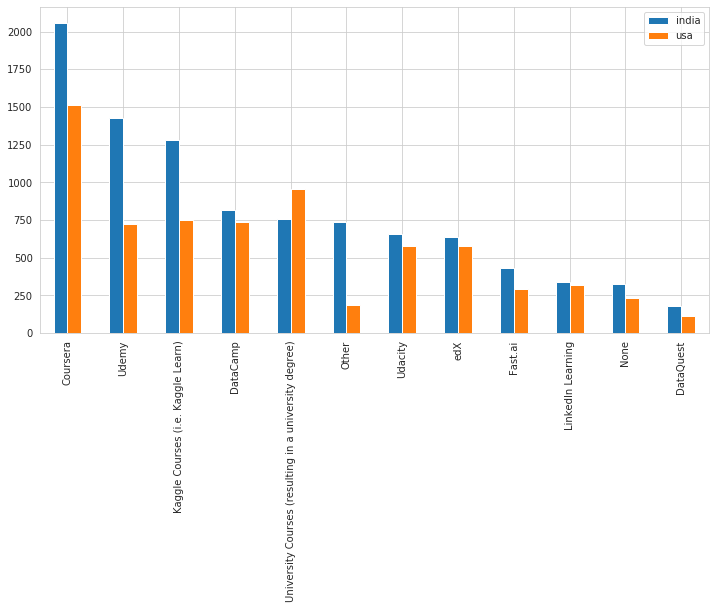

In [41]:
# learning resources total numbers
labels = undummy(india, "Q13", labels_only=True)
labels[5] = "Kaggle Courses"
labels[9] = "University Courses"

fig, ax = plt.subplots(figsize=figure_size)
ax.set_xticklabels(labels)
resources.plot(kind="bar", ax=ax)
plt.show()

In [42]:
resources_perc = total_to_perc(resources, india, usa, "india", "usa")

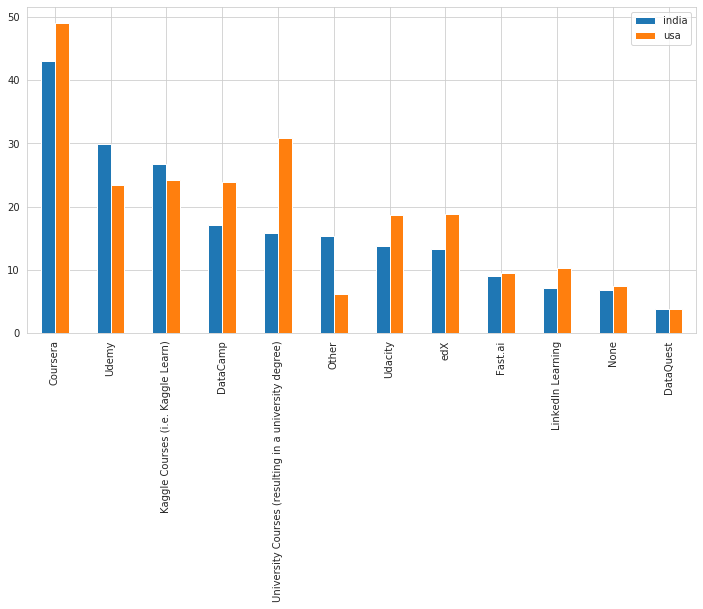

In [43]:
# learning resources percentages
fig, ax = plt.subplots(figsize=figure_size)
resources_perc.plot(kind="bar", ax=ax)
plt.show()

In [44]:
india_tools_dist = perc(india, "Q14").rename(columns={"Q14": "india"})
usa_tools_dist = perc(usa, "Q14").rename(columns={"Q14": "usa"})
df_tools = india_tools_dist.merge(right=usa_tools_dist, how="inner", left_index=True, right_index=True)

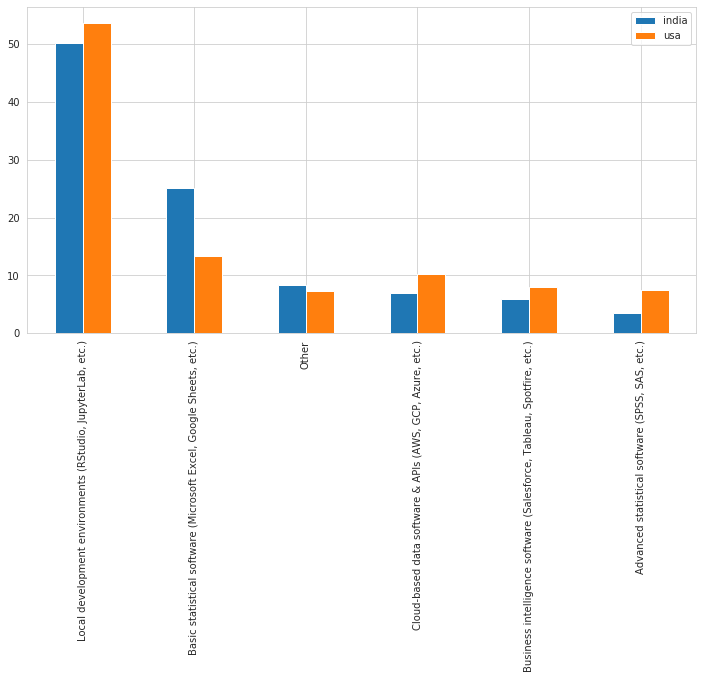

In [45]:
# tools percentages
fig, ax = plt.subplots(figsize=figure_size)
df_tools.plot(kind="bar", ax=ax)
plt.show()

In [46]:
cloud_india = undummy_single_col(india, "Q14")
cloud_usa = undummy_single_col(usa, "Q14")

cloud_comp = cloud_india.merge(right=cloud_usa, how="inner", left_index=True, right_index=True)
cloud_comp = cloud_comp.rename(columns={"value_x": "india", "value_y": "usa"})

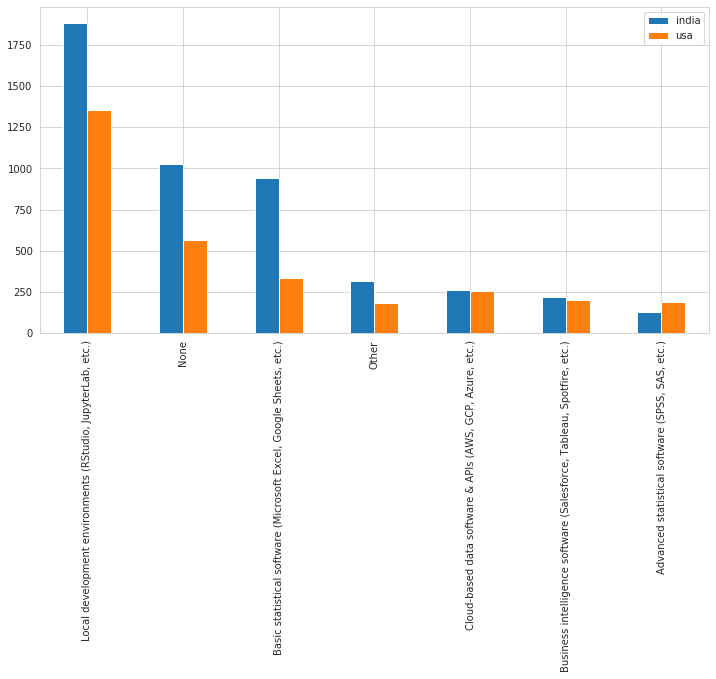

In [47]:
# tools total numbers
fig, ax = plt.subplots(figsize=figure_size)
cloud_comp.plot(kind="bar", ax=ax)
plt.show()

In [48]:
india_exp_dist = perc(india, "Q15").rename(columns={"Q15": "india"})
usa_exp_dist = perc(usa, "Q15").rename(columns={"Q15": "usa"})
df_exp = india_exp_dist.merge(right=usa_exp_dist, how="inner", left_index=True, right_index=True)

In [49]:
df_exp = df_exp.reindex(["I have never written code", "< 1 years", "1-2 years", "3-5 years", "5-10 years", "10-20 years", "20+ years"])

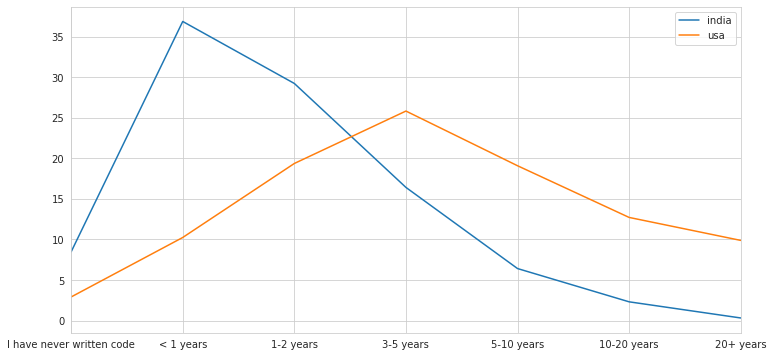

In [50]:
# programming experience percentages
fig, ax = plt.subplots(figsize=figure_size)
df_exp.plot(kind="line", ax=ax)
plt.show()

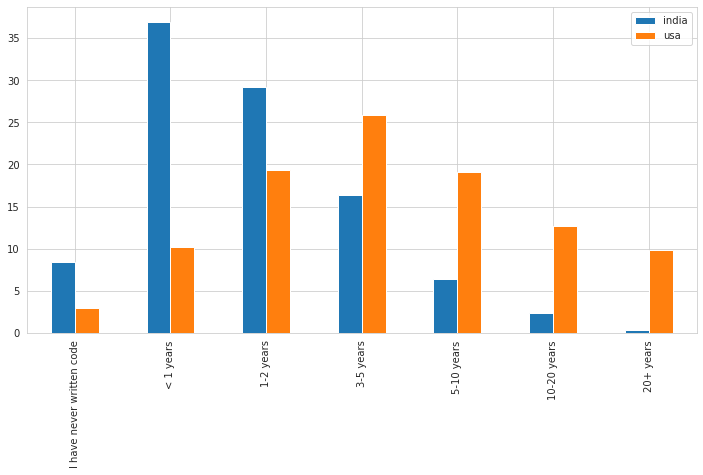

In [51]:
# programming experience percentages
fig, ax = plt.subplots(figsize=figure_size)
df_exp.plot(kind="bar", ax=ax)
plt.show()

In [52]:
languages_india = undummy(india, "Q18")
languages_india = languages_india.drop("2", axis=0)
languages_india = languages_india.rename(index={0: "Python"})
languages_usa = undummy(usa, "Q18")
languages_usa = languages_usa.drop("2", axis=0)
languages_usa = languages_usa.rename(index={0: "Python"})

languages = languages_india.merge(right=languages_usa, how="inner", left_index=True, right_index=True)
languages = languages.rename(columns={"value_x": "india", "value_y": "usa"})


In [53]:
languages_perc = total_to_perc(languages, india, usa, "india", "usa")

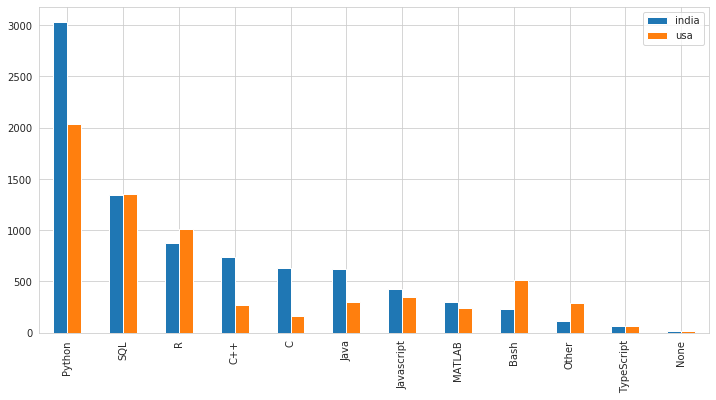

In [54]:
# programming languages total numbers
fig, ax = plt.subplots(figsize=figure_size)
languages.plot(kind="bar", ax=ax)
plt.show()

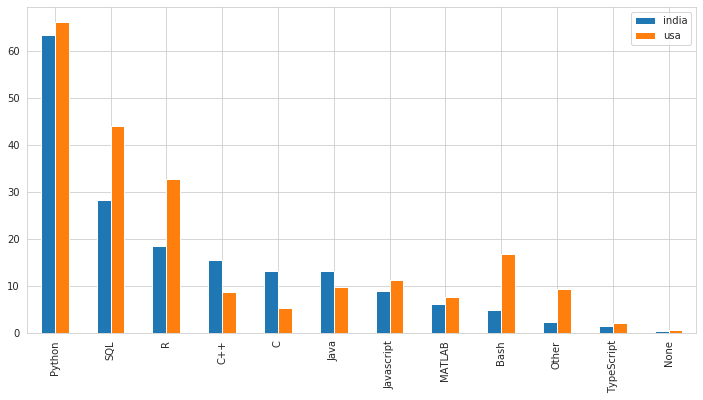

In [55]:
# programming languages percentages
fig, ax = plt.subplots(figsize=figure_size)
languages_perc.plot(kind="bar", ax=ax)
plt.show()

In [56]:
india_exp_ml_dist = perc(india, "Q23").rename(columns={"Q23": "india"})
usa_exp_ml_dist = perc(usa, "Q23").rename(columns={"Q23": "usa"})
df_exp_ml = india_exp_ml_dist.merge(right=usa_exp_dist, how="inner", left_index=True, right_index=True)

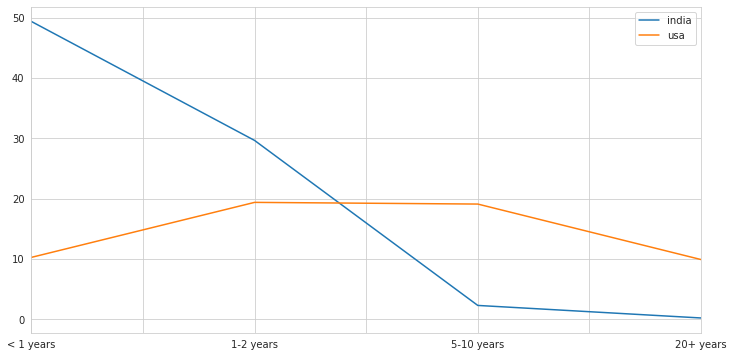

In [57]:
# machine learning experience percentages
fig, ax = plt.subplots(figsize=figure_size)
df_exp_ml.plot(kind="line", ax=ax)
plt.show()

In [58]:
ml_tools_india = undummy(india, "Q24")
ml_tools_india = ml_tools_india.rename(index={0: "Linear or Logistic Regression"})
ml_tools_usa = undummy(usa, "Q24")
ml_tools_usa = ml_tools_usa.rename(index={0: "Linear or Logistic Regression"})

ml_tools = ml_tools_india.merge(right=ml_tools_usa, how="inner", left_index=True, right_index=True)
ml_tools = ml_tools.rename(columns={"value_x": "india", "value_y": "usa"})

In [59]:
ml_tools = ml_tools.drop("1", axis=0)

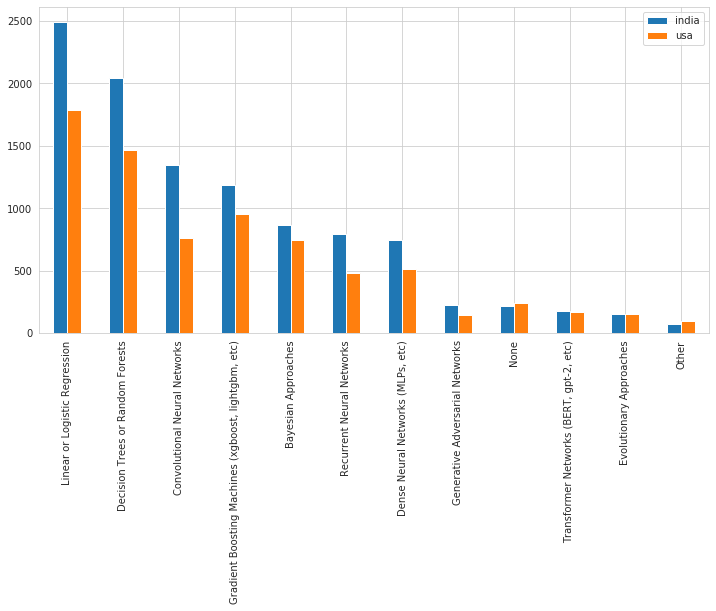

In [60]:
# machine learning tools total numbers
fig, ax = plt.subplots(figsize=figure_size)
ml_tools.plot(kind="bar", ax=ax)
plt.show()

In [61]:
ml_tools_perc = total_to_perc(ml_tools, india, usa, "india", "usa")

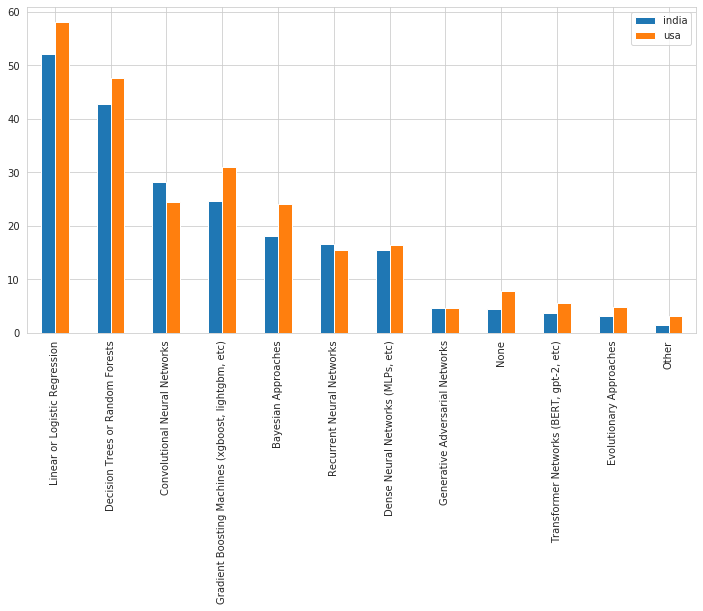

In [62]:
# machine learning tools percentage
fig, ax = plt.subplots(figsize=figure_size)
ml_tools_perc.plot(kind="bar", ax=ax)
plt.show()